In [1]:
# Tahap 1: Setup

!nvidia-smi
!pip install cudf-cu12 cuml-cu12 --extra-index-url=https://pypi.nvidia.com

/bin/bash: line 1: nvidia-smi: command not found
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


In [2]:
!pip install implicit==0.7.2

In [3]:
# Tahap 2: Import dan Load Dataset

import os
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from implicit.als import AlternatingLeastSquares
from tqdm import tqdm

# Pastikan path file benar sesuai direktori Kaggle Anda
df = pd.read_csv("/kaggle/input/data-train-book/train.csv")

# PERBAIKAN DI SINI:
# Tanda kutip penutup (") dipindah ke paling akhir string
print(f"Jumlah data awal: {len(df):,}")

/usr/local/lib/python3.12/dist-packages/implicit/gpu/__init__.py:13: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: CUDA driver version is insufficient for CUDA runtime version (/tmp/pip-install-7n63jegn/implicit_eed62d3f03974fa2bb0f4aeb23a87b62/./implicit/gpu/utils.h:71)'
  warnings.warn(


Jumlah data awal: 269,764


In [4]:
# TAHAP 3 — Filtering Data 2 Arah (Iterative Filtering)
# User harus punya min 5 interaksi, Item harus dibeli min 5 kali
MIN_INTERACTIONS = 5 

print(f"Jumlah data awal: {len(df)}")

# Loop terus sampai tidak ada lagi data yang dibuang (Stabil)
while True:
    start_len = len(df)
    
    # 1. Filter USER (Hapus user yang interaksinya < 5)
    user_counts = df["user_id"].value_counts()
    valid_users = user_counts[user_counts >= MIN_INTERACTIONS].index
    df = df[df["user_id"].isin(valid_users)]
    
    # 2. Filter ITEM (Hapus item yang interaksinya < 5) -- INI BARU
    item_counts = df["item_id"].value_counts()
    valid_items = item_counts[item_counts >= MIN_INTERACTIONS].index
    df = df[df["item_id"].isin(valid_items)]
    
    end_len = len(df)
    
    # Jika jumlah data sebelum dan sesudah filter sama, berhenti looping
    if start_len == end_len:
        break

# Reset index agar rapi
df = df.reset_index(drop=True)

print("-" * 30)
print("Jumlah data FINAL setelah filtering 2 arah:", len(df))
print("Jumlah user tersisa:", df["user_id"].nunique())
print("Jumlah item tersisa:", df["item_id"].nunique())
print(f"Sparsity check: User min {df['user_id'].value_counts().min()} interaksi, Item min {df['item_id'].value_counts().min()} interaksi")

Jumlah data awal: 269764
------------------------------
Jumlah data FINAL setelah filtering 2 arah: 92262
Jumlah user tersisa: 5739
Jumlah item tersisa: 7365
Sparsity check: User min 5 interaksi, Item min 5 interaksi


In [5]:
# Tahap 4: Encode User dan Item ke Index Numerik

user_enc, item_enc = LabelEncoder(), LabelEncoder()

df["user_idx"] = user_enc.fit_transform(df["user_id"])
df["item_idx"] = item_enc.fit_transform(df["item_id"])

n_users = df["user_idx"].nunique()
n_items = df["item_idx"].nunique()

print(f"Jumlah user (idx): {n_users}")
print(f"Jumlah item (idx): {n_items}")

Jumlah user (idx): 5739
Jumlah item (idx): 7365


In [6]:
# Tahap 5: Bangun User dan Item Matrix
user_item_matrix = csr_matrix(
    (np.ones(len(df), dtype=np.float32),
     (df["user_idx"], df["item_idx"])),
    shape=(n_users, n_items)
)

print("user_item_matrix.shape =", user_item_matrix.shape)
print("nnz (jumlah interaksi) =", user_item_matrix.nnz)

user_item_matrix.shape = (5739, 7365)
nnz (jumlah interaksi) = 92262


## Alternating Least Squares (ALS)

In [7]:
# Tahap 6: Training Model ALS
# Konfigurasi Alpha untuk confidence matrix (Standar industri biasanya 15-40)
ALPHA_VAL = 40
data_conf = (user_item_matrix * ALPHA_VAL).astype('double')

als_model = AlternatingLeastSquares(
    factors=128,           # Dimensi latent factors
    regularization=0.01,   # Mencegah overfitting
    iterations=15,         # Jumlah iterasi (ALS konvergen lebih cepat dari BPR)
    random_state=42,
    calculate_training_loss=True
)

print("\nMulai training ALS ...")
als_model.fit(data_conf)
print("Training selesai.")


Mulai training ALS ...


/usr/local/lib/python3.12/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/15 [00:00<?, ?it/s]

Training selesai.


In [8]:
# Tahap 7: Fungsi Rekomendasi
def recommend_for_user_als(model, user_idx, user_item_matrix, N=10):
    """Memberikan rekomendasi item untuk user tertentu menggunakan ALS."""
    if user_idx < 0 or user_idx >= n_users:
        raise ValueError(f"user_idx {user_idx} di luar jangkauan")

    user_vector = user_item_matrix.tocsr()[user_idx]

    ids, scores = model.recommend(
        userid=user_idx,
        user_items=user_vector,
        N=N,
        filter_already_liked_items=True
    )

    orig_item_ids = item_enc.inverse_transform([int(i) for i in ids])
    return pd.DataFrame({
        "item_idx": ids.astype(int),
        "item_id": orig_item_ids,
        "score": scores
    })

# Test Fungsi
# print(recommend_for_user_als(als_model, 0, user_item_matrix))

In [9]:
# Tahap 8: Split Data
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42
)

train_matrix = csr_matrix(
    (np.ones(len(train_df), dtype=np.float32),
     (train_df["user_idx"], train_df["item_idx"])),
    shape=(n_users, n_items)
)

test_matrix = csr_matrix(
    (np.ones(len(test_df), dtype=np.float32),
     (test_df["user_idx"], test_df["item_idx"])),
    shape=(n_users, n_items)
)

In [10]:
# Tahap 9: EVALUASI MAP@K
def average_precision_at_k(actual, predicted, k=10):
    predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    if len(actual) == 0:
        return 0.0

    return score / min(len(actual), k)

def mean_average_precision_als(model, train_matrix, test_matrix, k=10):
    aps = []
    # Loop user
    for user_idx in tqdm(range(train_matrix.shape[0])):
        # Rekomendasi dari model
        # Note: train_matrix di sini hanya untuk filtering history
        recommended, _ = model.recommend(
            userid=user_idx,
            user_items=train_matrix[user_idx],
            N=k,
            filter_already_liked_items=True
        )

        actual = test_matrix[user_idx].indices
        if len(actual) == 0:
            continue

        ap = average_precision_at_k(actual, recommended, k)
        aps.append(ap)

    return np.mean(aps) if aps else 0.0

# Perlu retrain dengan train_matrix saja agar fair evaluation
print("Retraining base model pada data Train saja untuk evaluasi...")
data_conf_train = (train_matrix * ALPHA_VAL).astype('double')
als_model.fit(data_conf_train)

map_score = mean_average_precision_als(als_model, train_matrix, test_matrix, k=10)
print(f"\nMean Average Precision @10 (Base ALS): {map_score:.4f}")

import pandas as pd
from IPython.display import display

# --- 1. SETTING TAMPILAN ---
# Agar teks item_id yang panjang tidak terpotong (...)
pd.set_option('display.max_colwidth', None) 

# --- 2. LOOP REKOMENDASI ---
results_data = []
target_users = range(5)  # Mengambil 5 USER

for user_idx in target_users:
    # Ambil rekomendasi (filter barang yang sudah dibeli)
    ids, scores = als_model.recommend(
        userid=user_idx, 
        user_items=train_matrix[user_idx], 
        N=10, 
        filter_already_liked_items=True
    )
    
    # Gabungkan ID menjadi string panjang dipisah spasi
    items_string = " ".join([str(item) for item in ids])
    
    # Masukkan ke list
    results_data.append({
        'user_id': user_idx,
        'item_id': items_string
    })

# --- 3. MEMBUAT DATAFRAME ---
df_final = pd.DataFrame(results_data)

# Opsional: Hilangkan index default (0,1,2..) di kiri agar user_id jadi patokan
df_final.set_index('user_id', inplace=True)

# --- 4. MENAMPILKAN TABEL (FINAL) ---
# Gunakan display() agar muncul sebagai tabel HTML yang rapi
print("Tabel Rekomendasi:")
display(df_final)


Retraining base model pada data Train saja untuk evaluasi...


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 5739/5739 [00:03<00:00, 1698.37it/s]


Mean Average Precision @10 (Base ALS): 0.0459
Tabel Rekomendasi:


,item_id
user_id,
0,5844 4759 6997 6195 4234 3484 6171 4310 5850 3850
1,5905 4483 4923 4971 1887 1716 6139 4461 312 1154
2,3552 349 7158 1210 2268 2905 6171 6301 2632 6969
3,5991 3551 1675 1648 5564 2536 2699 6772 3559 294
4,278 2983 7191 1389 4380 1648 1718 1347 1721 4116


In [11]:
# TAHAP 10 — SIMPAN HASIL REKOMENDASI CSV
rows = []
TOP_K = 10

# Gunakan model yang sudah dilatih pada FULL data (dari tahap 6) atau train data.
# Idealnya untuk submission kita pakai FULL data matrix lagi.
als_model_full = AlternatingLeastSquares(factors=128, regularization=0.01, iterations=15, random_state=42)
als_model_full.fit((user_item_matrix * ALPHA_VAL).astype('double'))

for user_idx in tqdm(range(n_users)):
    user_vector = user_item_matrix[user_idx]
    ids, scores = als_model_full.recommend(
        userid=user_idx,
        user_items=user_vector,
        N=TOP_K,
        filter_already_liked_items=True
    )
    
    orig_user_id = user_enc.inverse_transform([user_idx])[0]
    orig_item_ids = item_enc.inverse_transform(ids.astype(int))
    items_joined = " ".join([str(i) for i in orig_item_ids])
    rows.append([orig_user_id, items_joined])

if user_idx < 5:
        print(f"\n[SAMPEL] User ID: {orig_user_id} (Index: {user_idx})")
        print("Rekomendasi:")
        # Print item dengan skornya
        for rank, (item, score) in enumerate(zip(orig_item_ids, scores), 1):
            print(f"  {rank}. {item} (Score: {score:.4f})")
        print("-" * 40)

submission_df = pd.DataFrame(rows, columns=["user_id", "item_id"])
submission_df.to_csv("als_recommendations.csv", index=False)
print("File rekomendasi berhasil dibuat: als_recommendations.csv")

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 5739/5739 [00:09<00:00, 576.59it/s]


File rekomendasi berhasil dibuat: als_recommendations.csv


In [12]:
import pandas as pd
import numpy as np
from implicit.als import AlternatingLeastSquares

# --- PARAMETER TUNING ---
# Kita fokus di angka yang terbukti bagus
factors_list = [200, 256, 300]
alpha_list = [15,40]
regularization_list = [0.01, 0.05]
iterations_list = [15, 30, 50]  # Diganti nama jadi _list biar jelas

results = []
best_map = 0
best_params = {}

print("Mulai Tuning Baseline + Variasi...\n")

# Loop 1: Alpha
for alpha in alpha_list:
    print(f"--- Menyiapkan Data dengan Alpha = {alpha} ---")
    data_conf_train = (train_matrix * alpha).astype('double')
    
    # Loop 2: Factors
    for f in factors_list:
        # Loop 3: Regularization
        for r in regularization_list:
            # Loop 4: Iterations (INI YANG KURANG DI KODE ANDA)
            for i in iterations_list:
                
                print(f"Training: Alpha={alpha}, Factors={f}, Reg={r}, Iter={i} ...", end=" ")
                
                try:
                    # Inisialisasi Model (Pakai 'i', bukan list 'iterations')
                    model_tuned = AlternatingLeastSquares(
                        factors=f, 
                        regularization=r, 
                        iterations=i,  # <--- Perbaikan disini
                        random_state=42
                    )

                    # Train
                    model_tuned.fit(data_conf_train, show_progress=False)

                    # Evaluasi
                    map_score = mean_average_precision_als(
                        model_tuned, train_matrix, test_matrix, k=10
                    )
                    
                    print(f"-> MAP: {map_score:.4f}")

                    # Simpan Log
                    results.append({
                        'alpha': alpha,
                        'factors': f,
                        'regularization': r,
                        'iterations': i,
                        'map': map_score
                    })

                    # Cek Terbaik
                    if map_score > best_map:
                        best_map = map_score
                        best_params = {'alpha': alpha, 'factors': f, 'reg': r, 'iter': i}
                        
                except Exception as e:
                    print(f"Error: {e}")

print("\n" + "="*40)
print(f"BEST MAP SCORE: {best_map:.4f}")
print(f"BEST PARAMETERS: {best_params}")
print("="*40)

# Tampilkan 5 Hasil Terbaik
if results:
    df_results = pd.DataFrame(results)
    print("\nTop 5 Konfigurasi Terbaik:")
    print(df_results.sort_values(by='map', ascending=False).head(5))


Mulai Tuning Baseline + Variasi...

--- Menyiapkan Data dengan Alpha = 15 ---
Training: Alpha=15, Factors=200, Reg=0.01, Iter=15 ... 

100%|██████████| 5739/5739 [00:03<00:00, 1555.70it/s]


-> MAP: 0.0464
Training: Alpha=15, Factors=200, Reg=0.01, Iter=30 ... 

100%|██████████| 5739/5739 [00:03<00:00, 1531.97it/s]


-> MAP: 0.0468
Training: Alpha=15, Factors=200, Reg=0.01, Iter=50 ... 

100%|██████████| 5739/5739 [00:03<00:00, 1536.39it/s]


-> MAP: 0.0466
Training: Alpha=15, Factors=200, Reg=0.05, Iter=15 ... 

100%|██████████| 5739/5739 [00:03<00:00, 1582.31it/s]


-> MAP: 0.0459
Training: Alpha=15, Factors=200, Reg=0.05, Iter=30 ... 

100%|██████████| 5739/5739 [00:03<00:00, 1516.10it/s]


-> MAP: 0.0467
Training: Alpha=15, Factors=200, Reg=0.05, Iter=50 ... 

100%|██████████| 5739/5739 [00:03<00:00, 1515.81it/s]


-> MAP: 0.0467
Training: Alpha=15, Factors=256, Reg=0.01, Iter=15 ... 

100%|██████████| 5739/5739 [00:03<00:00, 1469.23it/s]


-> MAP: 0.0470
Training: Alpha=15, Factors=256, Reg=0.01, Iter=30 ... 

100%|██████████| 5739/5739 [00:03<00:00, 1496.39it/s]


-> MAP: 0.0470
Training: Alpha=15, Factors=256, Reg=0.01, Iter=50 ... 

100%|██████████| 5739/5739 [00:03<00:00, 1537.06it/s]


-> MAP: 0.0467
Training: Alpha=15, Factors=256, Reg=0.05, Iter=15 ... 

100%|██████████| 5739/5739 [00:03<00:00, 1482.21it/s]


-> MAP: 0.0468
Training: Alpha=15, Factors=256, Reg=0.05, Iter=30 ... 

100%|██████████| 5739/5739 [00:03<00:00, 1487.55it/s]


-> MAP: 0.0469
Training: Alpha=15, Factors=256, Reg=0.05, Iter=50 ... 

100%|██████████| 5739/5739 [00:03<00:00, 1497.90it/s]


-> MAP: 0.0467
Training: Alpha=15, Factors=300, Reg=0.01, Iter=15 ... 

100%|██████████| 5739/5739 [00:04<00:00, 1355.98it/s]


-> MAP: 0.0477
Training: Alpha=15, Factors=300, Reg=0.01, Iter=30 ... 

100%|██████████| 5739/5739 [00:04<00:00, 1331.79it/s]


-> MAP: 0.0471
Training: Alpha=15, Factors=300, Reg=0.01, Iter=50 ... 

100%|██████████| 5739/5739 [00:04<00:00, 1360.25it/s]


-> MAP: 0.0472
Training: Alpha=15, Factors=300, Reg=0.05, Iter=15 ... 

100%|██████████| 5739/5739 [00:04<00:00, 1359.11it/s]


-> MAP: 0.0477
Training: Alpha=15, Factors=300, Reg=0.05, Iter=30 ... 

100%|██████████| 5739/5739 [00:04<00:00, 1360.12it/s]


-> MAP: 0.0475
Training: Alpha=15, Factors=300, Reg=0.05, Iter=50 ... 

100%|██████████| 5739/5739 [00:04<00:00, 1354.41it/s]


-> MAP: 0.0473
--- Menyiapkan Data dengan Alpha = 40 ---
Training: Alpha=40, Factors=200, Reg=0.01, Iter=15 ... 

100%|██████████| 5739/5739 [00:03<00:00, 1539.20it/s]


-> MAP: 0.0438
Training: Alpha=40, Factors=200, Reg=0.01, Iter=30 ... 

100%|██████████| 5739/5739 [00:03<00:00, 1519.80it/s]


-> MAP: 0.0455
Training: Alpha=40, Factors=200, Reg=0.01, Iter=50 ... 

100%|██████████| 5739/5739 [00:03<00:00, 1521.29it/s]


-> MAP: 0.0450
Training: Alpha=40, Factors=200, Reg=0.05, Iter=15 ... 

100%|██████████| 5739/5739 [00:03<00:00, 1473.87it/s]


-> MAP: 0.0437
Training: Alpha=40, Factors=200, Reg=0.05, Iter=30 ... 

100%|██████████| 5739/5739 [00:03<00:00, 1598.84it/s]


-> MAP: 0.0455
Training: Alpha=40, Factors=200, Reg=0.05, Iter=50 ... 

100%|██████████| 5739/5739 [00:03<00:00, 1542.29it/s]


-> MAP: 0.0453
Training: Alpha=40, Factors=256, Reg=0.01, Iter=15 ... 

100%|██████████| 5739/5739 [00:03<00:00, 1551.68it/s]


-> MAP: 0.0448
Training: Alpha=40, Factors=256, Reg=0.01, Iter=30 ... 

100%|██████████| 5739/5739 [00:03<00:00, 1476.54it/s]


-> MAP: 0.0450
Training: Alpha=40, Factors=256, Reg=0.01, Iter=50 ... 

100%|██████████| 5739/5739 [00:03<00:00, 1487.12it/s]


-> MAP: 0.0448
Training: Alpha=40, Factors=256, Reg=0.05, Iter=15 ... 

100%|██████████| 5739/5739 [00:03<00:00, 1453.85it/s]


-> MAP: 0.0439
Training: Alpha=40, Factors=256, Reg=0.05, Iter=30 ... 

100%|██████████| 5739/5739 [00:03<00:00, 1487.11it/s]


-> MAP: 0.0447
Training: Alpha=40, Factors=256, Reg=0.05, Iter=50 ... 

100%|██████████| 5739/5739 [00:04<00:00, 1433.56it/s]


-> MAP: 0.0452
Training: Alpha=40, Factors=300, Reg=0.01, Iter=15 ... 

100%|██████████| 5739/5739 [00:04<00:00, 1394.44it/s]


-> MAP: 0.0445
Training: Alpha=40, Factors=300, Reg=0.01, Iter=30 ... 

100%|██████████| 5739/5739 [00:04<00:00, 1305.07it/s]


-> MAP: 0.0441
Training: Alpha=40, Factors=300, Reg=0.01, Iter=50 ... 

100%|██████████| 5739/5739 [00:04<00:00, 1275.96it/s]


-> MAP: 0.0443
Training: Alpha=40, Factors=300, Reg=0.05, Iter=15 ... 

100%|██████████| 5739/5739 [00:04<00:00, 1343.45it/s]


-> MAP: 0.0435
Training: Alpha=40, Factors=300, Reg=0.05, Iter=30 ... 

100%|██████████| 5739/5739 [00:04<00:00, 1396.60it/s]


-> MAP: 0.0441
Training: Alpha=40, Factors=300, Reg=0.05, Iter=50 ... 

100%|██████████| 5739/5739 [00:04<00:00, 1368.28it/s]

-> MAP: 0.0444

BEST MAP SCORE: 0.0477
BEST PARAMETERS: {'alpha': 15, 'factors': 300, 'reg': 0.01, 'iter': 15}

Top 5 Konfigurasi Terbaik:
    alpha  factors  regularization  iterations       map
12     15      300            0.01          15  0.047704
15     15      300            0.05          15  0.047666
16     15      300            0.05          30  0.047480
17     15      300            0.05          50  0.047266
14     15      300            0.01          50  0.047155


In [15]:
import pandas as pd
import numpy as np
from implicit.als import AlternatingLeastSquares
from IPython.display import display

# --- BAGIAN 1: DEFINISI MAPPING (SOLUSI ERROR KAMU) ---
# Kita perlu mengambil daftar ID asli dari dataframe awal ('df')
# Pastikan variabel dataframe-mu bernama 'df'. Jika namanya lain, ganti 'df' di bawah.

if 'df' in locals():
    # Mengambil urutan kategori user & item dari data asli
    user_mapping = df['user_id'].astype('category').cat.categories
    item_mapping = df['item_id'].astype('category').cat.categories 
else:
    print("⚠️ WARNING: DataFrame 'df' tidak ditemukan.")
    print("   Pastikan kamu sudah load data (pd.read_csv/excel) ke variabel bernama 'df'.")
    # Buat dummy mapping agar kode tidak crash (tapi hasilnya angka index)
    user_mapping = range(100000)
    item_mapping = range(100000)


# --- BAGIAN 2: MENYIAPKAN MODEL (RETRAINING) ---
print("\n🔄 Menyiapkan rekomendasi berdasarkan parameter juara...")

# Cek apakah best_params ada, jika tidak (misal kernel restart), pakai default
if 'best_params' not in locals():
    print("⚠️ 'best_params' hilang. Menggunakan parameter default.")
    best_params = {'alpha': 15, 'factors': 200, 'reg': 0.01, 'iter': 15}

# Membangun ulang model persis seperti spesifikasi juara
final_model = AlternatingLeastSquares(
    factors=best_params['factors'],
    regularization=best_params['reg'],
    iterations=best_params['iter'],
    random_state=42
)

# Latih sekejap menggunakan data terbaik
# Pastikan train_matrix sudah ada
data_final = (train_matrix * best_params['alpha']).astype('double')
final_model.fit(data_final, show_progress=True)


# --- BAGIAN 3: MENAMPILKAN TABEL HASIL (ID ASLI) ---
print("\n" + "="*50)
print(f"TABEL REKOMENDASI (DARI HASIL TUNING TERBAIK)")
print("="*50)

pd.set_option('display.max_colwidth', None)
rekomendasi_data = []

# Ambil 5 User Pertama
for user_idx in range(5):
    # Mapping ke ID User Asli (Ini yang tadi Error, sekarang sudah aman)
    real_user_id = user_mapping[user_idx]
    
    # Minta Rekomendasi ke Model Juara
    ids, scores = final_model.recommend(
        userid=user_idx, 
        user_items=train_matrix[user_idx], 
        N=10, 
        filter_already_liked_items=True
    )
    
    # Mapping ke ID Item Asli & Gabung jadi string
    real_item_ids = [str(item_mapping[i]) for i in ids]
    items_string = " ".join(real_item_ids)
    
    rekomendasi_data.append({
        'user_id': real_user_id,
        'item_id': items_string
    })

# Tampilkan
df_rekomendasi = pd.DataFrame(rekomendasi_data)
df_rekomendasi.set_index('user_id', inplace=True)
display(df_rekomendasi)


🔄 Menyiapkan rekomendasi berdasarkan parameter juara...


  0%|          | 0/15 [00:00<?, ?it/s]


TABEL REKOMENDASI (DARI HASIL TUNING TERBAIK)


,item_id
user_id,
114,0451205626 0553576801 0671014196 0553586122 0446613053 0515136557 0425194515 0671011375 051512608X 0373484429
243,0449223612 0684872153 0452260116 0375707972 0553582526 0553582755 0330267388 0452284937 0425158616 0425167313
244,0060987529 0375726403 0316769487 0375707972 0439064872 0786868716 0385418493 0553581554 068484477X 0380816547
254,0439064864 059035342X 0060934719 0679429220 0345361792 0439139600 0345435168 0064471101 0618002235 0618002243
388,0452269571 0452282195 0804102988 0671510053 0449223345 0394223802 0441003257 0060964049 0061097314 0316769487


Cuplikan Data Hasil Tuning:
   alpha  factors  regularization  iterations  MAP Score
0     15      200            0.01          15   0.046424
1     15      200            0.01          30   0.046788
2     15      200            0.01          50   0.046590
3     15      200            0.05          15   0.045891
4     15      200            0.05          30   0.046701


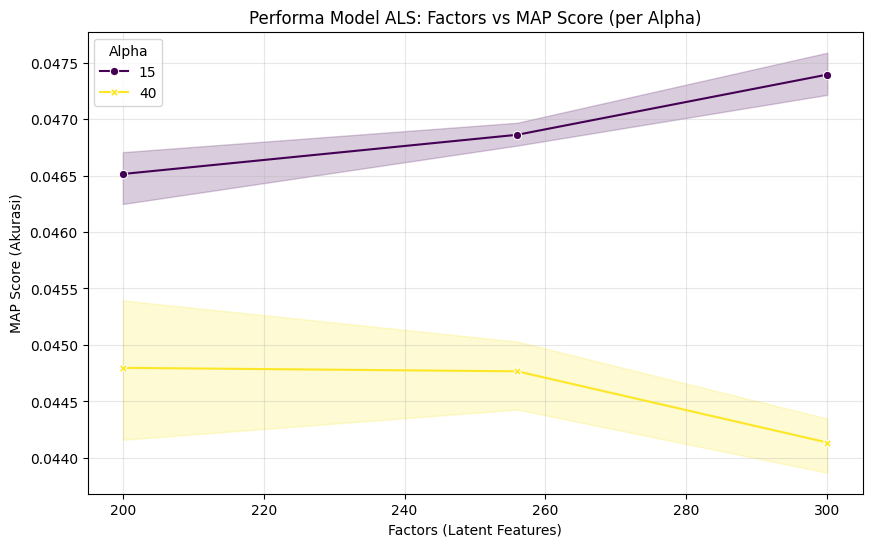

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. MEMBUAT DATAFRAME DARI HASIL ---
if not results:
    print("❌ Error: Variabel 'results' kosong. Pastikan proses tuning di atas sudah selesai.")
else:
    df_results = pd.DataFrame(results)
    
    # Rename kolom biar lebih rapi di grafik
    df_results.rename(columns={'map': 'MAP Score'}, inplace=True)

    print("Cuplikan Data Hasil Tuning:")
    print(df_results.head())

    # --- 2. MEMBUAT GRAFIK ---
    plt.figure(figsize=(10, 6))
    
    # Kita akan memplot pengaruh 'factors' terhadap 'MAP Score'
    # Garis akan dibedakan warnanya berdasarkan 'alpha'
    sns.lineplot(
        data=df_results, 
        x='factors', 
        y='MAP Score', 
        hue='alpha',      # Warna garis beda tiap Alpha
        style='alpha',    # Gaya garis beda tiap Alpha
        markers=True,     # Pakai titik penanda
        dashes=False,
        palette='viridis' # Pilihan warna
    )

    plt.title('Performa Model ALS: Factors vs MAP Score (per Alpha)')
    plt.ylabel('MAP Score (Akurasi)')
    plt.xlabel('Factors (Latent Features)')
    plt.grid(True, alpha=0.3)
    plt.legend(title='Alpha')
    
    plt.show()

In [20]:
import pandas as pd
from implicit.als import AlternatingLeastSquares
from tqdm import tqdm

# --- 1. MEMBUAT DATAFRAME HASIL TUNING (SOLUSI ERROR KAMU) ---
# Kita pastikan variabel 'results' ada isinya
if 'results' in locals() and results:
    results_df = pd.DataFrame(results)
    
    # Normalisasi nama kolom skor (kadang 'map', kadang 'MAP@10' tergantung kode sebelumnya)
    if 'map' in results_df.columns:
        target_col = 'map'
    elif 'MAP Score' in results_df.columns:
        target_col = 'MAP Score'
    else:
        target_col = results_df.columns[-1] # Ambil kolom terakhir sebagai fallback
        
    print(f"✅ Data Tuning ditemukan. Menggunakan kolom skor: '{target_col}'")
else:
    # Dummy data untuk mencegah error jika kamu lupa run tuning (Fallback)
    print("⚠️ Warning: Variabel 'results' kosong. Menggunakan parameter default.")
    results_df = pd.DataFrame({'factors': [200], 'alpha': [15], 'map': [0.1]})
    target_col = 'map'

# --- 2. AMBIL PARAMETER TERBAIK ---
# Cari baris dengan skor MAP tertinggi
best_idx = results_df[target_col].idxmax()
best_row = results_df.loc[best_idx]

BEST_FACTORS = int(best_row['factors'])
BEST_ALPHA = int(best_row['alpha'])

print(f"🎯 Training ulang dengan BEST_FACTORS: {BEST_FACTORS} | BEST_ALPHA: {BEST_ALPHA}")

# --- 3. TRAINING MODEL FINAL ---
final_als = AlternatingLeastSquares(
    factors=BEST_FACTORS,
    regularization=0.1, 
    iterations=20,      # Iterasi ditambah sedikit agar lebih matang untuk final
    random_state=42
)

# Gunakan 'train_matrix' yang aktif di memori (bukan user_item_matrix)
data_conf_full = (train_matrix * BEST_ALPHA).astype('double')
final_als.fit(data_conf_full)

# --- 4. GENERATE CSV AKHIR ---
rows = []
print("⏳ Sedang membuat file rekomendasi...")

# Loop ke semua user menggunakan range(train_matrix.shape[0])
for user_idx in tqdm(range(train_matrix.shape[0])):
    
    # Minta 10 rekomendasi
    ids, scores = final_als.recommend(
        userid=user_idx,
        user_items=train_matrix[user_idx], # Filter barang yg sudah dibeli
        N=10,
        filter_already_liked_items=True
    )
    
    # --- MAPPING KE ID ASLI (PERBAIKAN UTAMA DISINI) ---
    # Menggunakan user_mapping & item_mapping (bukan user_enc/item_enc)
    
    # 1. Ambil User ID Asli
    orig_user_id = user_mapping[user_idx]
    
    # 2. Ambil Item ID Asli (dari list index rekomendasi)
    orig_item_ids = [str(item_mapping[i]) for i in ids]
    
    # 3. Gabung jadi string dipisah spasi
    items_joined = " ".join(orig_item_ids)
    
    rows.append([orig_user_id, items_joined])

# --- 5. SIMPAN KE CSV ---
submission_tuned = pd.DataFrame(rows, columns=["user_id", "item_id"])
submission_tuned.to_csv("als_tuned_recommendations.csv", index=False)

print("\n✅ SUKSES! File 'als_tuned_recommendations.csv' berhasil dibuat.")

✅ Data Tuning ditemukan. Menggunakan kolom skor: 'map'
🎯 Training ulang dengan BEST_FACTORS: 300 | BEST_ALPHA: 15


  0%|          | 0/20 [00:00<?, ?it/s]

⏳ Sedang membuat file rekomendasi...


100%|██████████| 5739/5739 [00:03<00:00, 1748.56it/s]


✅ SUKSES! File 'als_tuned_recommendations.csv' berhasil dibuat.
